# はじめに

本ノートブックでは、[Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic) を題材として、データサイエンスの基礎を学ぶ。
基本的な流れは、[Spaceship Titanic: A complete guide](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide) を参考させてもらっているが、（データサイエンスを学ぶことも1つの目的であるため）細かい記載の修正や解説などが追記されていることがある。

In this notebook, we will learn the basics of data science in Japanese using the [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic) as a subject. The basic flow is referenced from [Spaceship Titanic: A complete guide](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide), but there may be minor revisions and additional explanations to aid in learning data science.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# ライブラリ

まず初めに、データサイエンスで用いる基本的なライブラリをimportする。

First of all, we will import the basic libraries used in data science.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', font_scale = 1.4)

以下では、警告を無視する設定を追加する。例えば、ページ下部のコード内における `sns.histplot` では、PandasとSeabornのバージョンの互換性に関する警告（将来のバージョンで、非推奨となる機能が含まれている）が出るが、ここでは（本質的でないと判断し）抑制する。

Here, we will add a setting to ignore warnings. For example, in the code at the bottom of the page, the `sns.histplot` function may generate a warning regarding the compatibility between the Pandas and Seaborn versions, indicating that certain features will be deprecated in future versions. We will suppress these warnings as they are deemed non-essential in this context."

If anyone knows the reason why seaborn is abbreviated as `sns`, please let me know. I would think that if seaborn were to be abbreviated, it would be `sb` ...

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

本ノートブックでは、いくつかの機械学習モデルの中から、適切なモデルを選択することを行う。そのため、複数のモデルをインポートする。

In [4]:
# ロジスティック回帰モデル
from sklearn.linear_model import LogisticRegression

# k最近傍法
from sklearn.neighbors import KNeighborsClassifier

# サポートベクトルマシン
from sklearn.svm import SVC

# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

# LigthGBM（勾配ブースティング）
from lightgbm import LGBMClassifier

# CatBoost
from catboost import CatBoostClassifier

# Gaussianナイーブベイズ
from sklearn.naive_bayes import GaussianNB

In [5]:
# モデルを比較する際に、トレーニング時間を計りたいため
import time

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# データの基本的な部分を確認

In [7]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

# (行数, 列数)
print('train.shape:', train.shape)
print('test.shape:', test.shape)

train.shape: (8693, 14)
test.shape: (4277, 13)


In [8]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# 欠損値の確認

なぜ、欠損値を確認するか？

In [9]:
# trainの欠損値
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
# testの欠損値
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

# 重複行の確認

なぜ、重複行を確認するか

In [11]:
train.duplicated().sum()

0

In [12]:
test.duplicated().sum()

0

# 特徴量について

特徴量は、以下の3つに分類できる：

- continuous
- categorical
- descriptive / qualitative

| 特徴量|aaa |
|---|--- |
| PassengerId | descriptive / qualitative |
| HomePlanet |categorical |
| CryoSleep |categorical |
| Cabin | descriptive / qualitative |
| Destination |categorical |
| Age |continuous |
| VIP | categorical |
| RoomService |continuous |
| FoodCourt |continuous |
| ShoppingMail |continuous |
| Spa | continuous|
| VRDeck |continuous |
| Name |descriptive / qualitative |

In [13]:
# datatypeの確認
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

# 探索的データ解析

EDA（Exploratory Data Analysis）

Text(0.5, 1.0, 'Target distribution')

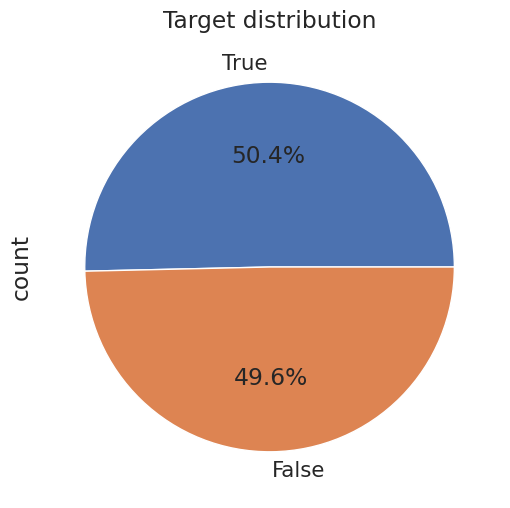

In [14]:
# 図のサイズ
plt.figure(figsize=(6, 6))

train['Transported'].value_counts().plot.pie(
    autopct = '%1.1f%%'
).set_title("Target distribution")

上図から、半分半分ということがわかる

乗客の年齢分布について視覚化する

Text(0.5, 0, 'Age (years)')

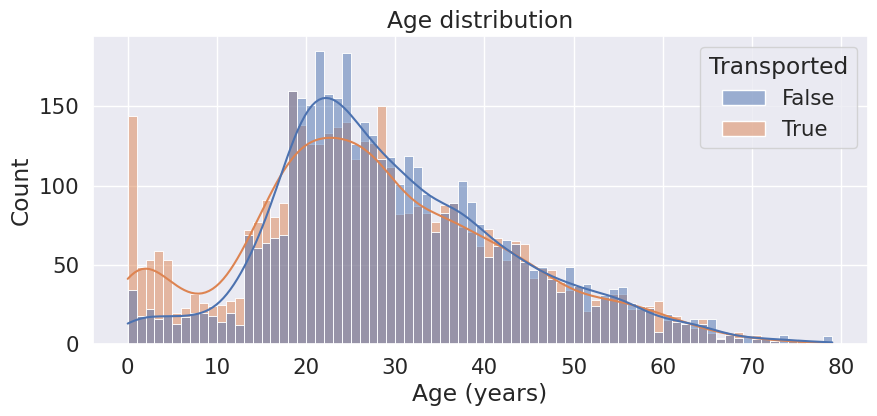

In [15]:
plt.figure(figsize = (10, 4))

sns.histplot(data=train, x ='Age', hue='Transported', binwidth=1, kde = True)

plt.title('Age distribution')
plt.xlabel('Age (years)')

0-18, 18-25, 25以上で、傾向が読み取れる

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
→この辺は、金銭系なので、それで、まとめて傾向を見る
→傾向が似ていれば、1つの特徴量を作れる

...後で加筆するかも

カテゴリ変数の視覚化

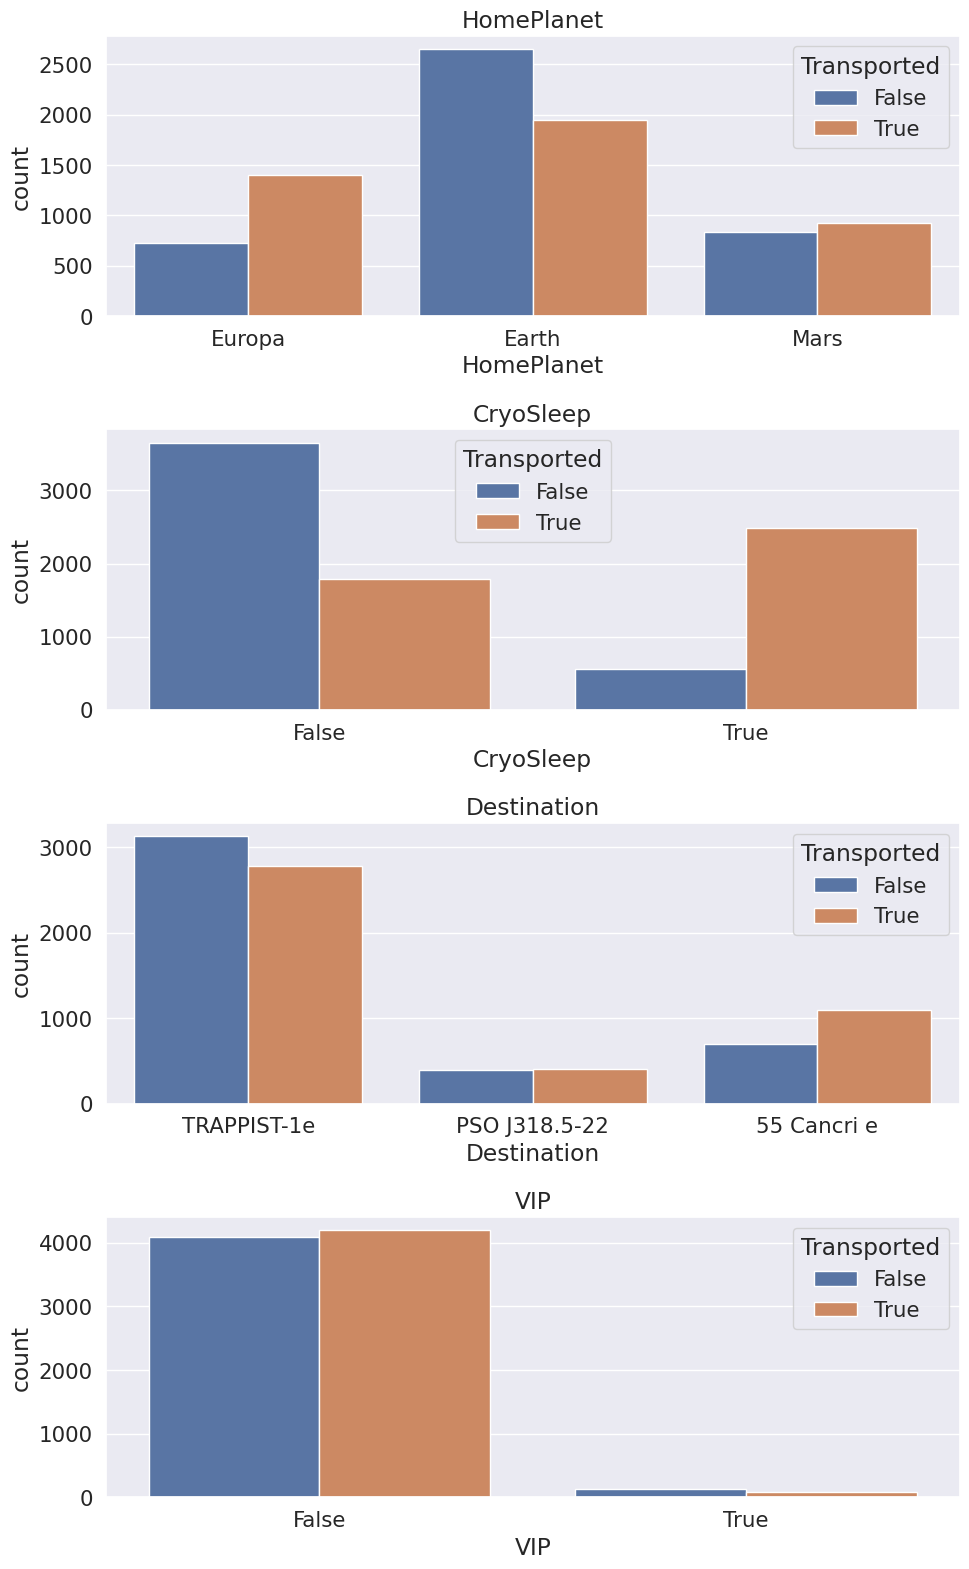

In [16]:
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize = (10, 16))

for i, var_name in enumerate(cat_feats):
    ax = fig.add_subplot(4, 1, i + 1)
    sns.countplot(
        data = train,
        x = var_name,
        axes = ax,
        hue = 'Transported'
    )
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

In [17]:
qual_feats = ['PassengerId', 'Cabin', 'Name']

train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


### Feature engineering

#### 年齢について

新しい特徴量である `Age_group` を定義する

In [18]:
# train
# Age_groupを定義し、空文字で初期化する
# np.nanによる初期化だと、データタイプの不整合が起きる
train['Age_group'] = ''

train.loc[train['Age'] <= 12, 'Age_group'] = 'Age_0-12'
train.loc[(train['Age'] > 12) & (train['Age'] < 18), 'Age_group'] = 'Age_13-17'
train.loc[(train['Age'] >= 18 ) & (train['Age'] <= 25), 'Age_group'] = 'Age_18-25'
train.loc[(train['Age'] > 25 ) & (train['Age'] <= 30), 'Age_group'] = 'Age_26-30'
train.loc[(train['Age'] >= 30 ) & (train['Age'] <= 50), 'Age_group'] = 'Age_31-50'
train.loc[train['Age'] > 50, 'Age_group'] = 'Age_51+'

In [19]:
# test
test['Age_group'] = ''

test.loc[test['Age'] <= 12, 'Age_group'] = 'Age_0-12'
test.loc[(test['Age'] > 12) & (test['Age'] < 18), 'Age_group'] = 'Age_13-17'
test.loc[(test['Age'] >= 18 ) & (test['Age'] <= 25), 'Age_group'] = 'Age_18-25'
test.loc[(test['Age'] > 25 ) & (test['Age'] <= 30), 'Age_group'] = 'Age_26-30'
test.loc[(test['Age'] >= 30 ) & (test['Age'] <= 50), 'Age_group'] = 'Age_31-50'
test.loc[test['Age'] > 50, 'Age_group'] = 'Age_51+'

Text(0.5, 1.0, 'Age group distribution')

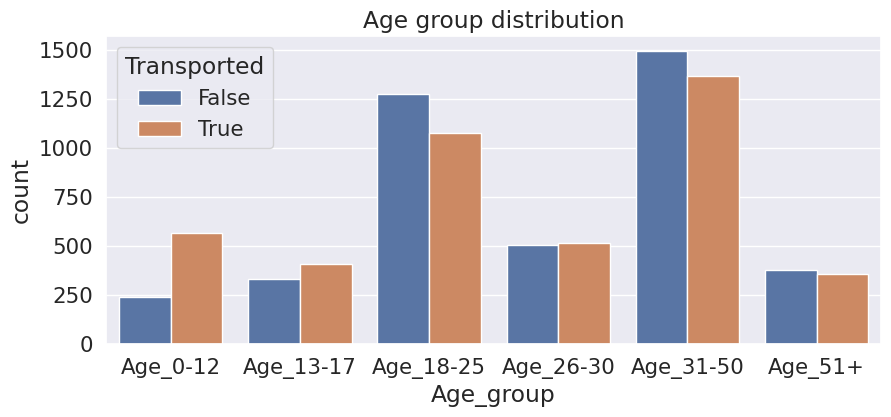

In [20]:
# 作成した特徴量に対して、グラフ化する
plt.figure(figsize=(10, 4))
g = sns.countplot(
    data = train,
    x = 'Age_group',
    hue = 'Transported',
    order = [
        'Age_0-12',
        'Age_13-17',
        'Age_18-25',
        'Age_26-30',
        'Age_31-50',
        'Age_51+'
    ]
)
plt.title('Age group distribution')

Age_0-12 については、transportedされている数が、そうでないのに比べ、多い

この対応忘れてたのでやる

In [21]:
y = train['Transported'].copy().astype(int)
X = train.drop('Transported', axis = 1).copy()

data = pd.concat([X, test], axis=0).reset_index(drop=True)

In [22]:
# X = data[data['PassengerId'].isin(train['PassangerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify = y, train_size = 0.8, test_size = 0.2, random_state = 0)

### どのモデルを使うか

ここでは複数の機械学習モデルを、（モデル名をkey、モデルのインスタンスをvalueとした）辞書形式で定義している。

In [24]:
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes" : GaussianNB()
}

ハイパーパラメータを設定する

grid searchについて追記

In [25]:
LR_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.25, 0.5, 0.75, 1, 1.25, 1.5],
    'max_iter' : [50, 100, 150]
}

KNN_grid = {
    'n_neighbors' : [3, 5, 7, 9],
    'p' : [1, 2]
}

SVC_grid = {
    'C' : [0.25, 0.5, 0.75, 1, 1.25, 1.5],
    'kernel' : ['linear', 'rbf'],
    'gamma' : ['scale', 'auto']
}

RF_grid = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'max_depth' : [4, 6, 8, 10, 12]
}

boosted_grid = {
    'n_estimators' : '50, 100, 150, 200',
    'max_depth' : [4, 8, 12],
    'learning_rate' : [0.05, 0.1, 0.15]
}

NB_grid = {
    'var_sommthing' : [1e-10, 1e-9, 1e-8, 1e-7]
}

In [26]:
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes" : NB_grid
}

In [27]:
i = 0

clf_best_params = classifiers.copy()

# 各モデルの検証精度とトレーニング時間を保存するdataframe
valid_scores = pd.DataFrame(
    {
        'Classifier' : classifiers.keys(),
        'Validation accuracy' : np.zeros(len(classifiers)),
        'Training time' : np.zeros(len(classifiers))
    }
)

for key, classifier in classifiers.items():
    start = time.time()
    
    # グリッドサーチって何？
    clf = GridSearchCV(
        estimator = classifier,
        param_grid = grid[key],
        n_jobs = -1,
        cv = None
    )
    
#     clf.fit(X_train, y_train)　 # ここでエラーになる
#     valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)
    
#     clf_best_params[key] = clf.best_params_
    
#     stop = time.time()
#     valid_scores.iloc[i, 2] = np.round((stop - start)/60, 2)
    
#     print('Model:', key)
#     print('Training time (mins):', valid_scores.iloc[i, 2])
#     print('')
    
#     i += 1
    

# モデリング

上記のモデリングの選択は、一旦、参考テキストの選択をそのまま採用することにする。というのも、まずは一連の流れを最後まで進むのが大切だと思ったため。

というわけで、LGBMとCatBoostを採用する。

In [28]:
# best_classifiers = {
#     "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state = 0),
#     "CatBoost" : CatBoostClassifier(
#         **clf_best_params["CatBoost"],
#         verbose = False,
#         random_state = 0
#     )
# }

ちょっとずるいが、端折る

In [29]:
clf_best_params = {
    'LogisticRegression': {'C': 0.5, 'max_iter': 100, 'penalty': 'l2'},
    'KNN': {'n_neighbors': 9, 'p': 2},
    'SVC': {'C': 1.25, 'gamma': 'scale', 'kernel': 'rbf'},
    'RandomForest': {'max_depth': 10, 'n_estimators': 250},
    'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100},
    'CatBoost': {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100},
    'NaiveBayes': {'var_smoothing': 1e-07}
}


In [30]:
clf_best_params

{'LogisticRegression': {'C': 0.5, 'max_iter': 100, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 2},
 'SVC': {'C': 1.25, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 10, 'n_estimators': 250},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100},
 'CatBoost': {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100},
 'NaiveBayes': {'var_smoothing': 1e-07}}

### モデリング

クロスバリデーションを使用して、モデルをトレーニングする


In [31]:
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=0),
}

In [32]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
#     for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
#         # Get training and validation sets
#         X_train, X_valid = X[train_idx], X[val_idx]
#         y_train, y_valid = y[train_idx], y[val_idx]

#         # Train model
#         clf = classifier
#         clf.fit(X_train, y_train)

#         # Make predictions and measure accuracy
#         preds += clf.predict_proba(X_test)[:,1]
#         score += clf.score(X_valid, y_valid)

#     # Average accuracy    
#     score=score/FOLDS
    
#     # Stop timer
#     stop = time.time()

#     # Print accuracy and time
#     print('Model:', key)
#     print('Average validation accuracy:', np.round(100*score,2))
#     print('Training time (mins):', np.round((stop - start)/60,2))
#     print('')
    
# # Ensemble predictions
# preds=preds/(FOLDS*len(best_classifiers))